In [1]:
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import datetime as dt
from collections import Counter

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv(r'C:\Users\Mourya Kuntamukkala\Desktop\Courses\SMDM\Final Project\Edited\Biden_No_Retweet_Full_Text_Before_Election.csv',error_bad_lines=False)

C:\Users\Mourya Kuntamukkala\AppData\Local\Temp\ipykernel_7276\375709397.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(r'C:\Users\Mourya Kuntamukkala\Desktop\Courses\SMDM\Final Project\Edited\Biden_No_Retweet_Full_Text_Before_Election.csv',error_bad_lines=False)


In [3]:
df.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,United States,Twitter for Android,0,54,192,0
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,United States,Twitter for iPhone,1,2476,3334,1
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       15098 non-null  object
 1   Tweet_id   15098 non-null  int64 
 2   Verified   15098 non-null  bool  
 3   Tweet      15098 non-null  object
 4   User       15098 non-null  object
 5   Location   11032 non-null  object
 6   Source     15098 non-null  object
 7   Likes      15098 non-null  int64 
 8   Followers  15098 non-null  int64 
 9   Following  15098 non-null  int64 
 10  Retweets   15098 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 1.2+ MB


In [5]:
df.shape

(15098, 11)

Preprocessing

In [6]:
df['Date'] = df['Date'].apply(lambda x: x[:-6] if '+' in x else x)
df.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,United States,Twitter for Android,0,54,192,0
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,United States,Twitter for iPhone,1,2476,3334,1
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0


In [7]:

df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [8]:
df.dtypes

Date         datetime64[ns]
Tweet_id              int64
Verified               bool
Tweet                object
User                 object
Location             object
Source               object
Likes                 int64
Followers             int64
Following             int64
Retweets              int64
dtype: object

In [9]:
df.isnull().sum()

Date            0
Tweet_id        0
Verified        0
Tweet           0
User            0
Location     4066
Source          0
Likes           0
Followers       0
Following       0
Retweets        0
dtype: int64

In [10]:
df['Source'].value_counts()

Twitter Web App            5910
Twitter for iPhone         4565
Twitter for Android        3267
Twitter for iPad            705
TweetDeck                   150
                           ... 
Tweeting Neural Network       1
Moa Bridge                    1
Airtime Pro                   1
SocialPilot.co                1
Restream.io                   1
Name: Source, Length: 87, dtype: int64

In [11]:
df['Location'].nunique()

3200

In [12]:
tweets_list = df['Tweet'].tolist()
len(tweets_list)

15098

In [13]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

15046

In [14]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)

list

In [15]:
df['Tweet'].duplicated().sum()

52

In [16]:
df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(15046, 11)

In [17]:
df['Tweet'].duplicated().sum()

0

removing emojis

In [18]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

df['Processed_Tweet']=df.Tweet.apply(remove_emoji)

In [19]:
count = 0
for i in df['Processed_Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Processed_Tweet']==i].index,inplace = True)
        count+=1
    
count

0

In [20]:
df['Processed_Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

removing retweets that is the tweet which has RT

In [21]:
df['Processed_Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Processed_Tweet']]  #Remove RT substring

In [22]:
df['Processed_Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

removing usernames

In [23]:
df['Processed_Tweet'] = [re.sub('@[^\s]+', ' ', i) for i in df['Processed_Tweet']] #remove usernames

In [24]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

removing anyh urls that are present

In [25]:
df['Processed_Tweet'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', i) for i in df['Processed_Tweet']] #Remove urls

In [26]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

removing the hashtags symbol from the tweets

In [27]:
df['Processed_Tweet'] = [re.sub(r'#([^\s]+)', r'\1', i) for i in df['Processed_Tweet']] # remove the # in #hashtag

In [28]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        GeorgeWill , it’s so sad you wake up everyday ...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 Biden formally implicated in Ukrain...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls? Why Biden's 'Nationwide Lead' Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

using library to preprocess the tweets

In [29]:
import preprocessor as p #Module for faster preprocessing specifically for tweets

In [30]:
df['Processed_Tweet'] = [p.clean(i) for i in df['Processed_Tweet']]

In [31]:
df['Processed_Tweet']

0        VP Biden I wish you wouldn't debate Trump unle...
1        GeorgeWill , its so sad you wake up everyday f...
2        Question:If doesnt pick a woman of color, woul...
3        Right? Biden formally implicated in Ukraine sc...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls? Why Biden's 'Nationwide Lead' Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [32]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")

C:\Users\Mourya Kuntamukkala\AppData\Local\Temp\ipykernel_7276\1181258175.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")


In [33]:
df["Processed_Tweet"]

0        VP Biden I wish you wouldn t debate Trump unle...
1        GeorgeWill   its so sad you wake up everyday f...
2        Question If doesnt pick a woman of color  woul...
3        Right  Biden formally implicated in Ukraine sc...
4        These idiots let Trump do anything he wants  W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don t want to leave out the left  Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls  Why Biden s  Nationwide Lead  Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [34]:
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case 

In [35]:
df["Processed_Tweet"]

0        vp biden i wish you wouldn t debate trump unle...
1        georgewill   its so sad you wake up everyday f...
2        question if doesnt pick a woman of color  woul...
3        right  biden formally implicated in ukraine sc...
4        these idiots let trump do anything he wants  w...
                               ...                        
15041    other than going big by eulogizing stromthurmo...
15042    don t want to leave out the left  show your su...
15043    some chatter about biden maybe activating reso...
15044    fake polls  why biden s  nationwide lead  over...
15045    joe biden trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [36]:
df.Processed_Tweet =  df.Processed_Tweet.str.replace("amp", "")

In [37]:
df['Processed_Tweet'][11] #Sample tweet

'hey guys  it s time to realize we ve been duped   granted biden is a horrible idea  just maybe if he wins patriots will get off their asses and take america back   '

Exploratory data analysis

In [38]:
df['User'].value_counts()

Hotpage_News      544
jacketrose86      174
mobygrapefan       71
defeatthedevil     67
deepen915          61
                 ... 
IiiDenzel           1
OzRant              1
SuePBC65            1
AlenLLC             1
GraphicMedia4       1
Name: User, Length: 8270, dtype: int64

In [39]:
df.query('User == "Hotpage_News"').Processed_Tweet.tolist()

['lincoln project trolls trump by adding laugh track to disastrous chris wallace interview   biden trump gop republican democrat democrats liberal conservative independent covid   covid coronavirus',
 'we sent our kids to summer c  it shutdown with a covid    outbreak after just a few days  this is what school will look like    covid   covid coronavirus trump biden pandemic virus mask schoolreopening',
 'trump blasts china in public  but privately trump org imports tons of chinese goods   biden trump gop republican democrat democrats liberal conservative independent covid   covid coronavirus',
 'giants  gabe kapler becomes first mlb manager to kneel during national anthem   biden trump gop republican democrat democrats liberal conservative independent covid   covid coronavirus',
 'trump says the game is over for him if athletes kneel during national anthem   biden trump gop republican democrat democrats liberal conservative independent covid   covid coronavirus',
 'walmart  mcdonalds  

C:\Users\Mourya Kuntamukkala\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


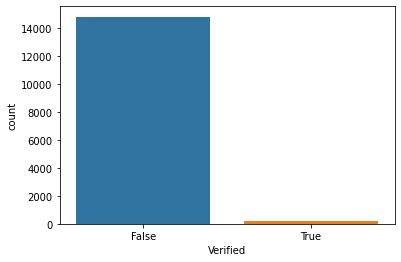

In [40]:
bar = sns.countplot(df['Verified'])

In [41]:
df['Verified'].value_counts()

False    14830
True       216
Name: Verified, dtype: int64

In [42]:
df_verified = df.query('Verified == True')

In [43]:
df_verified['User'].value_counts()

AndyOstroy         15
JudicialWatch       9
The_NewArab         7
DemsAbroad          7
Varneyco            7
                   ..
Lee4USCongress      1
UnivisionNews       1
DrJasonJohnson      1
GordonRepinski      1
plagiarismtoday     1
Name: User, Length: 121, dtype: int64

In [44]:
df_verified.query('User == "AndyOstroy"').Processed_Tweet.tolist()

['its intellectually dishonest  and quite hypocritical  for liberals who preach unity and bipartisanship to be losing their damn minds because one republican is gonna speak at the democratic convention    johnkasich kasich biden',
 'we are now at a new cray cray low in the trump presidency where he s challenged biden to a duel to see who can  ace  the  is this a lion or a monkey   cognitive test    chriswallace',
 'humiliating   historic    landslide  its coming     trump election     biden',
 'hey like how you cried daddy  daddy  please dont let them make me go to vietnam  before he bought you those deferments  coward    trump chriswallace biden',
 'how do you feel about susanrice as biden s vp ',
 'i believe on nov rd were going to witness the biggest  most humiliating  most historic backlash against and republicans this country has ever seen and could ever have imagined    election     biden trump',
 'hey moron   all of this darkness  despair  dysfunction  disease  death you re show

In [45]:
days = df['Date'].dt.day.tolist()

In [46]:
no_of_days = Counter(days)
no_of_days

Counter({21: 2084,
         20: 1862,
         19: 1712,
         18: 1322,
         17: 1573,
         16: 1638,
         15: 2020,
         14: 1884,
         13: 951})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

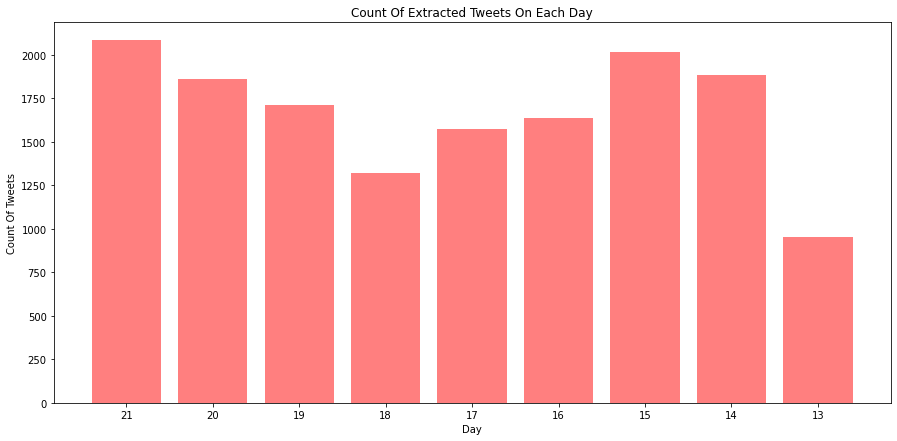

In [47]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

In [48]:
hours = df['Date'].dt.hour.tolist()

In [49]:
no_of_hours = Counter(hours)
no_of_hours

Counter({23: 857,
         22: 917,
         21: 891,
         20: 829,
         19: 828,
         18: 1107,
         17: 938,
         16: 953,
         15: 867,
         14: 834,
         13: 740,
         12: 560,
         11: 423,
         10: 260,
         9: 156,
         8: 157,
         7: 198,
         6: 237,
         5: 290,
         4: 397,
         3: 475,
         2: 628,
         1: 780,
         0: 724})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

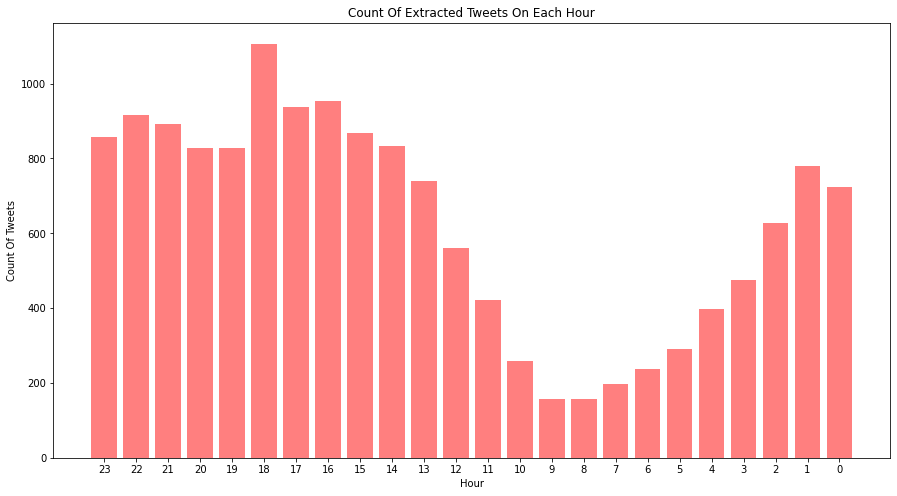

In [50]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

In [51]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer()


removing stopwords

In [52]:
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words)
print(stop_words)

['yourself', 'just', 'should', 'm', "you're", 'each', 'by', "didn't", 'did', "wouldn't", 'it', 'any', 'is', "wasn't", 'same', 'haven', 'why', 'after', "mightn't", 'don', 'our', 'couldn', 'isn', 'but', "doesn't", 'o', 'have', "weren't", 'she', 'll', "you'd", 'having', "should've", 'myself', 'her', 'because', 'aren', 'if', 'them', 'doing', 'ma', 'most', 'ourselves', 'was', 'how', 'some', 'what', 'won', 'or', 're', 'before', "don't", 'such', 'd', "couldn't", 'will', 'yours', "hadn't", 'themselves', 'me', 'being', "it's", 'are', 'all', 'too', "shouldn't", 'out', 'nor', 'with', 'we', 'ain', 'i', "aren't", 'up', "you've", "needn't", 'y', 'a', 'been', "that'll", 'when', 'they', 'yourselves', "mustn't", 'he', 'who', 'him', 'now', 'doesn', 'hasn', 'my', 'then', 'more', 'you', 'until', 'didn', 'itself', 'other', 'few', "isn't", 'am', 'while', 'both', 'shouldn', 'at', 'from', 'for', 'an', 'between', 'further', 'that', 'their', 'so', 'himself', 'of', 'ours', 'whom', "you'll", 'own', 'in', "she's",

In [53]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))   #Remove stopwords

In [54]:
df['Processed_Tweet']

0        vp biden wish debate trump unless debate trump...
1        georgewill sad wake everyday forgetting george...
2        question doesnt pick woman color would black c...
3        right biden formally implicated ukraine scanda...
4        idiots let trump anything wants biden gets ele...
                               ...                        
15041    going big eulogizing stromthurmond look right ...
15042    want leave left show support election hearts f...
15043    chatter biden maybe activating resources fight...
15044    fake polls biden nationwide lead trump says no...
15045                   joe biden trump police armed teeth
Name: Processed_Tweet, Length: 15046, dtype: object

Tokenizing

In [55]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: tokenizer.tokenize(x))

In [56]:
df['Processed_Tweet']

0        [vp, biden, wish, debate, trump, unless, debat...
1        [georgewill, sad, wake, everyday, forgetting, ...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formally, implicated, ukraine, ...
4        [idiots, let, trump, anything, wants, biden, g...
                               ...                        
15041    [going, big, eulogizing, stromthurmond, look, ...
15042    [want, leave, left, show, support, election, h...
15043    [chatter, biden, maybe, activating, resources,...
15044    [fake, polls, biden, nationwide, lead, trump, ...
15045            [joe, biden, trump, police, armed, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

Stemming

In [57]:
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(text)

In [58]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: [lemmatize_stemming(i) for i in x]) # stemming

In [59]:
df['Processed_Tweet']

0        [vp, biden, wish, debat, trump, unless, debat,...
1        [georgewil, sad, wake, everyday, forget, georg...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formal, implic, ukrain, scandal...
4        [idiot, let, trump, anyth, want, biden, get, e...
                               ...                        
15041    [go, big, eulog, stromthurmond, look, right, l...
15042    [want, leav, left, show, support, elect, heart...
15043    [chatter, biden, mayb, activ, resourc, fight, ...
15044    [fake, poll, biden, nationwid, lead, trump, sa...
15045               [joe, biden, trump, polic, arm, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

In [60]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: [i for i in x if len(i)>2])

In [61]:
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,United States,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru..."
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg..."
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ..."
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,United States,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal..."
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e..."
...,...,...,...,...,...,...,...,...,...,...,...,...
15041,2020-07-13 10:57:58,1282630342038499329,False,Other than going big by eulogizing #StromThurm...,robertson_alton,"Fort Worth, or thereabouts.",Twitter Web App,0,1004,4999,0,"[big, eulog, stromthurmond, look, right, look,..."
15042,2020-07-13 10:56:26,1282629958205145091,False,Don't want to leave out the left! Show your su...,GraphicMedia4,NaN,Twitter Web App,0,1,0,0,"[want, leav, left, show, support, elect, heart..."
15043,2020-07-13 10:53:50,1282629302199164928,False,Some chatter about #Biden maybe activating res...,copiousjawnt,"Lehigh Valley, PA",Twitter for Android,0,84,210,0,"[chatter, biden, mayb, activ, resourc, fight, ..."
15044,2020-07-13 10:53:46,1282629284524433409,False,Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...,blinova14,NaN,Twitter Web App,4,836,432,0,"[fake, poll, biden, nationwid, lead, trump, sa..."


modifying the tweets to feed them into the model

In [62]:
texts = []
texts = df.Processed_Tweet.apply(lambda x: [i for i in x] )

In [63]:
all_words = []
for i in texts:
    all_words.append(" ".join(i))

In [64]:
text = []
for i in texts:
    for j in i:
        text.append(j)

In [65]:
len(text)

227438

In [66]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

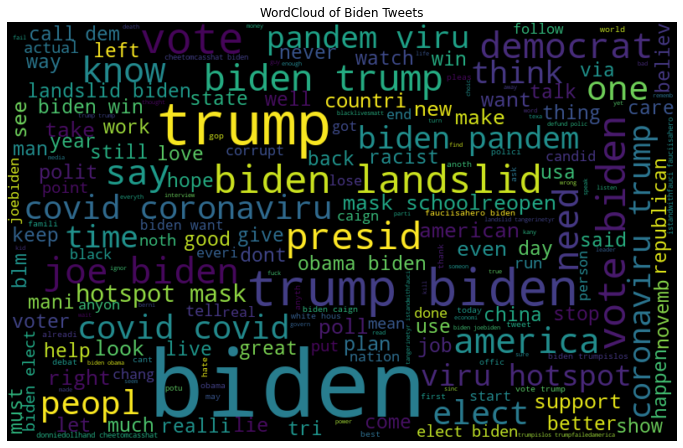

In [67]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Biden Tweets")
plt.show()

SENTIMENT ANALYSIS

In [68]:
from textblob import TextBlob

In [69]:
pol=[]
for Tweet in all_words:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)

In [70]:
len(pol)

15046

In [71]:
len(text)

227438

In [72]:
df['Processed_Tweet']

0        [biden, wish, debat, trump, unless, debat, tru...
1        [georgewil, sad, wake, everyday, forget, georg...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formal, implic, ukrain, scandal...
4        [idiot, let, trump, anyth, want, biden, get, e...
                               ...                        
15041    [big, eulog, stromthurmond, look, right, look,...
15042    [want, leav, left, show, support, elect, heart...
15043    [chatter, biden, mayb, activ, resourc, fight, ...
15044    [fake, poll, biden, nationwid, lead, trump, sa...
15045               [joe, biden, trump, polic, arm, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

classidying tweets into positive,negative and neutral

In [73]:
positive=0
negative=0
neutral=0
for i in pol:
    if i>0:
        positive+=1
    elif i<0:
        negative+=1
    else:
        neutral+=1
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positive Tweets: 5953
Negative Tweets: 3050
Neutral Tweets 6043


In [74]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Mourya
[nltk_data]     Kuntamukkala\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [75]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores= []
for i in all_words:
    sentiment_scores.append([sid.polarity_scores(i)])

In [76]:
value = []
for i in sentiment_scores:
    for dict1 in i:
        value.append(list(dict1.values()))

In [77]:
sentimental_score_df = pd.DataFrame(data = value, columns = ['Negative','Neutral','Positive','Compound'])
sentimental_score_df

,Negative,Neutral,Positive,Compound
0,0.214,0.619,0.167,-0.3612
1,0.204,0.694,0.102,-0.3612
2,0.000,1.000,0.000,0.0000
3,0.266,0.734,0.000,-0.4404
4,0.148,0.493,0.359,0.4019
...,...,...,...,...
15041,0.180,0.820,0.000,-0.6808
15042,0.000,0.810,0.190,0.4588
15043,0.206,0.794,0.000,-0.6369
15044,0.121,0.623,0.257,0.5423


In [78]:
sentimental_score_df['val'] = sentimental_score_df['Compound'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x > 0 else 'Negative'))
sentimental_score_df.head()

,Negative,Neutral,Positive,Compound,val
0,0.214,0.619,0.167,-0.3612,Negative
1,0.204,0.694,0.102,-0.3612,Negative
2,0.000,1.000,0.000,0.0000,Neutral
3,0.266,0.734,0.000,-0.4404,Negative
4,0.148,0.493,0.359,0.4019,Positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

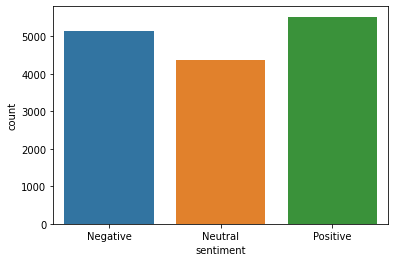

In [79]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score_df['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)

In [80]:
filepath = r"C:\Users\Mourya Kuntamukkala\Desktop\Courses\SMDM\Final Project\Edited\NRC Emotion Lexicon.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)
len(emolex_df)

86343

In [81]:
emotions={'positive':0, 'negative':0, 'surprise':0,'sadness':0,
          'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [82]:
word_emotion=dict()
for i in range(0,86343):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association  

In [83]:
for i in range(0,15046):
    text=df['Tweet'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[k]+=word_emotion[j][k]

In [84]:
emotions

{'positive': 5752.0,
 'negative': 5936.0,
 'surprise': 1491.0,
 'sadness': 2759.0,
 'anger': 3044.0,
 'joy': 1994.0,
 'trust': 3538.0,
 'fear': 3265.0,
 'anticipation': 2296.0,
 'disgust': 1944.0}

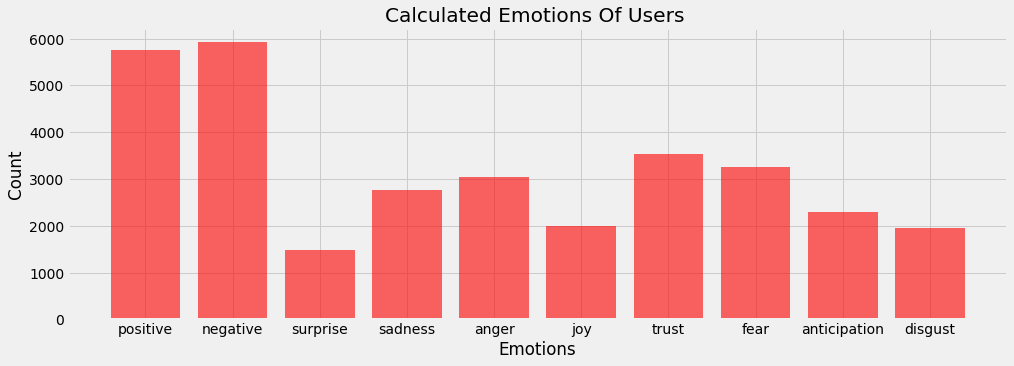

In [85]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions.keys()),list(emotions.values()),color='red',alpha = 0.6)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Calculated Emotions Of Users ')
plt.show()

In [86]:
df.Location  = df.Location.fillna('USA')

In [87]:
f = [i for i in df['Location'] if type(i) != str]
f

[]

In [88]:
df.Location = df.Location.apply(lambda x: x.replace('United States','USA'))

In [89]:
df.Location.value_counts()

USA                        5487
First star to the right     174
Florida, USA                158
Washington, DC              157
Earth                       136
                           ... 
My office...                  1
Behind a log, NC              1
Orange Co.                    1
Gadigal land                  1
NEVADA                        1
Name: Location, Length: 3195, dtype: int64

In [90]:
locations = []
locations_1 = []

locations = [i.split(',')[-1] for i in df['Location']]
locations_1 =  [i.split(',')[0] for i in df['Location']]
df['Processed_Location'] = locations_1
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,USA,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru...",USA
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg...",East Aurora
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ...",Nashville
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,USA,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal...",USA
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e...",Purgatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15041,2020-07-13 10:57:58,1282630342038499329,False,Other than going big by eulogizing #StromThurm...,robertson_alton,"Fort Worth, or thereabouts.",Twitter Web App,0,1004,4999,0,"[big, eulog, stromthurmond, look, right, look,...",Fort Worth
15042,2020-07-13 10:56:26,1282629958205145091,False,Don't want to leave out the left! Show your su...,GraphicMedia4,USA,Twitter Web App,0,1,0,0,"[want, leav, left, show, support, elect, heart...",USA
15043,2020-07-13 10:53:50,1282629302199164928,False,Some chatter about #Biden maybe activating res...,copiousjawnt,"Lehigh Valley, PA",Twitter for Android,0,84,210,0,"[chatter, biden, mayb, activ, resourc, fight, ...",Lehigh Valley
15044,2020-07-13 10:53:46,1282629284524433409,False,Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...,blinova14,USA,Twitter Web App,4,836,432,0,"[fake, poll, biden, nationwid, lead, trump, sa...",USA


In [91]:
df1 = df

In [92]:
df1['sentiment'] = sentimental_score_df['val']

In [93]:
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,USA,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru...",USA,Negative
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg...",East Aurora,Negative
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ...",Nashville,Neutral
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,USA,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal...",USA,Negative
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e...",Purgatory,Positive


In [94]:
df1.to_csv('Location.csv',index = False)

In [95]:
df1['day'] = df.Date.dt.day
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,USA,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru...",USA,Negative,21
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg...",East Aurora,Negative,21
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ...",Nashville,Neutral,21
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,USA,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal...",USA,Negative,21
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e...",Purgatory,Positive,21


C:\Users\Mourya Kuntamukkala\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='day', ylabel='count'>

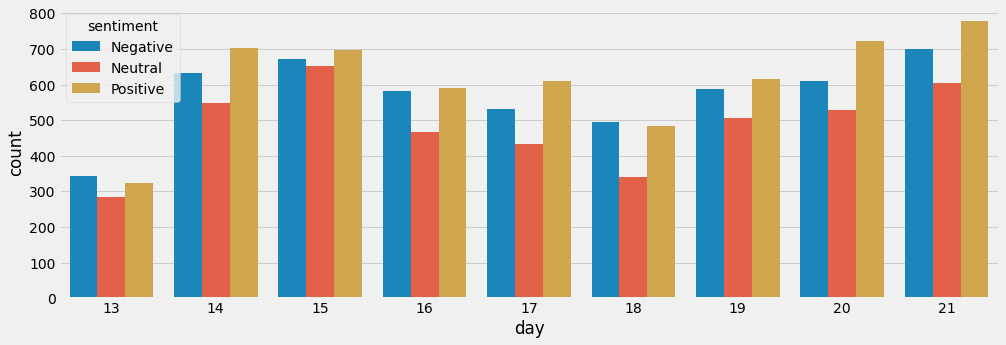

In [96]:
sns.countplot(df['day'],hue = df['sentiment'])

Predictions

In [97]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [98]:
le = LabelEncoder() 
  
df1['sentiment_1']= le.fit_transform(df1['sentiment']) 

In [99]:
df1

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day,sentiment_1
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,USA,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru...",USA,Negative,21,0
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg...",East Aurora,Negative,21,0
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ...",Nashville,Neutral,21,1
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,USA,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal...",USA,Negative,21,0
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e...",Purgatory,Positive,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15041,2020-07-13 10:57:58,1282630342038499329,False,Other than going big by eulogizing #StromThurm...,robertson_alton,"Fort Worth, or thereabouts.",Twitter Web App,0,1004,4999,0,"[big, eulog, stromthurmond, look, right, look,...",Fort Worth,Negative,13,0
15042,2020-07-13 10:56:26,1282629958205145091,False,Don't want to leave out the left! Show your su...,GraphicMedia4,USA,Twitter Web App,0,1,0,0,"[want, leav, left, show, support, elect, heart...",USA,Positive,13,2
15043,2020-07-13 10:53:50,1282629302199164928,False,Some chatter about #Biden maybe activating res...,copiousjawnt,"Lehigh Valley, PA",Twitter for Android,0,84,210,0,"[chatter, biden, mayb, activ, resourc, fight, ...",Lehigh Valley,Negative,13,0
15044,2020-07-13 10:53:46,1282629284524433409,False,Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...,blinova14,USA,Twitter Web App,4,836,432,0,"[fake, poll, biden, nationwid, lead, trump, sa...",USA,Positive,13,2


In [100]:
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(all_words).toarray()
y = df1['sentiment_1']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
# NEGATIVE == 0
# NEUTRAL == 1
# POSITIVE == 2

DECISION TREE

In [102]:
classifier_DT = DecisionTreeClassifier()
classifier_DT.fit(X_train, y_train)
y_pred_DT = classifier_DT.predict(X_test)

In [103]:
accuracy_score_DT = accuracy_score(y_test, y_pred_DT)
precision_score_DT = precision_score(y_test, y_pred_DT , average = 'micro')
recall_score_DT = recall_score(y_test, y_pred_DT , average = 'micro')
f1_score_DT = f1_score(y_test, y_pred_DT , average = 'micro')
print("Accuracy Score: " , accuracy_score_DT)
print("Precision Score: " , precision_score_DT)
print("Recall Score: " , recall_score_DT)
print("F1 Score: " , f1_score_DT)

Accuracy Score:  0.8068232166592822
Precision Score:  0.8068232166592822
Recall Score:  0.8068232166592822
F1 Score:  0.8068232166592824


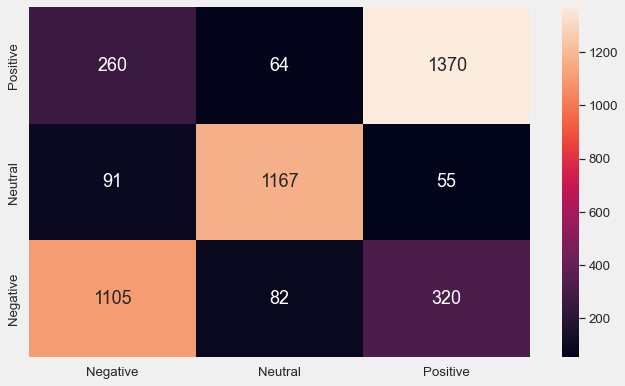

In [104]:
cm_DT = confusion_matrix(y_test, y_pred_DT)

      # neg # neutr  # pos
# pos #  232   65      1397
# neu #  87   1175     51
# neg # 1104   82      321

df_cm_DT = pd.DataFrame(cm_DT, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_DT, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories ,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

RANDOM FOREST CLASSIFIER

In [105]:
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)
y_pred_RF = classifier_RF.predict(X_test)

In [106]:
accuracy_score_RF = accuracy_score(y_test, y_pred_RF)
precision_score_RF = precision_score(y_test, y_pred_RF , average = 'micro')
recall_score_RF = recall_score(y_test, y_pred_RF, average = 'micro')
f1_score_RF = f1_score(y_test, y_pred_RF, average = 'micro')
print("Accuracy Score: " , accuracy_score_RF)
print("Precision Score: " , precision_score_RF)
print("Recall Score: " , recall_score_RF)
print("F1 Score: " , f1_score_RF)

Accuracy Score:  0.8524590163934426
Precision Score:  0.8524590163934426
Recall Score:  0.8524590163934426
F1 Score:  0.8524590163934426


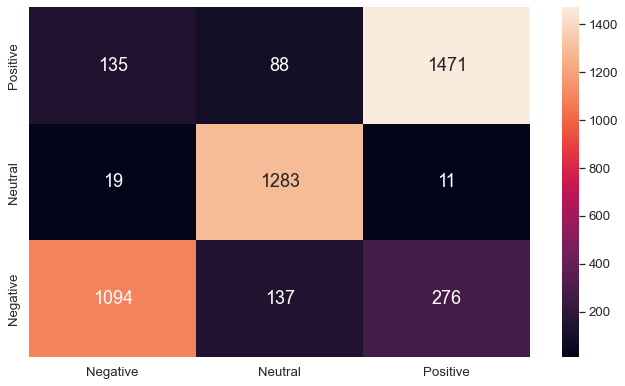

In [107]:
cm_RF = confusion_matrix(y_test, y_pred_RF)

      # neg # neutr  # pos
# pos # 198    92     1404
# neu #  53   1233      27
# neg # 1120   121     266

df_cm_RF = pd.DataFrame(cm_RF, range(3), range(3))
categories = ['Negative','Neutral','Positive']
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_RF, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

NAIVE BAYES

In [108]:
classifier_NB = MultinomialNB()
classifier_NB.fit(X_train, y_train)
y_pred_NB = classifier_NB.predict(X_test)

In [109]:
accuracy_score_NB = accuracy_score(y_test, y_pred_NB)
precision_score_NB = precision_score(y_test, y_pred_NB , average = 'micro')
recall_score_NB = recall_score(y_test, y_pred_NB, average = 'micro')
f1_score_NB = f1_score(y_test, y_pred_NB, average = 'micro')
print("Accuracy Score: " , accuracy_score_NB)
print("Precision Score: " , precision_score_NB)
print("Recall Score: " , recall_score_NB)
print("F1 Score: " , f1_score_NB)

Accuracy Score:  0.745680106335844
Precision Score:  0.745680106335844
Recall Score:  0.745680106335844
F1 Score:  0.745680106335844


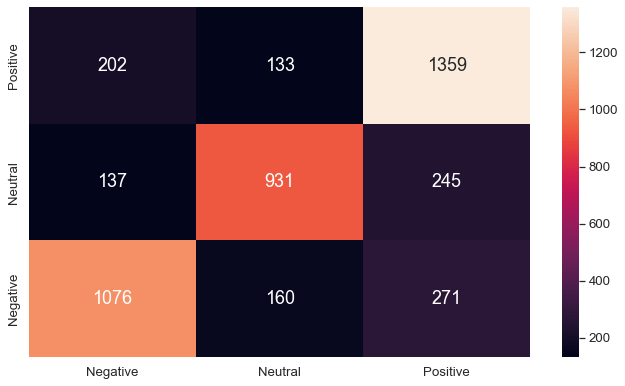

In [110]:
cm_NB = confusion_matrix(y_test, y_pred_NB)

      # neg # neutr  # pos
# pos # 202    133     1359
# neu # 137   931      245
# neg # 1076  160      271

df_cm_NB = pd.DataFrame(cm_NB, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_NB, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

COMPARING THE MODELS

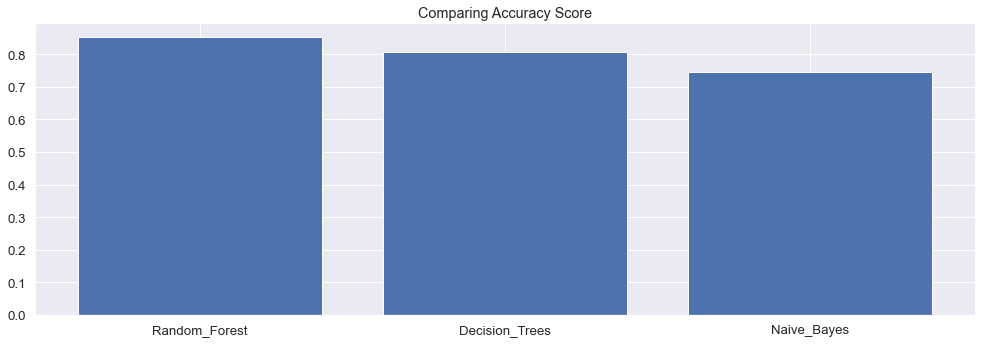

In [111]:
Accuracy = [accuracy_score_RF, accuracy_score_DT, accuracy_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy)
plt.xticks(Accuracy_pos, Methods)
plt.title('Comparing Accuracy Score')
plt.show()

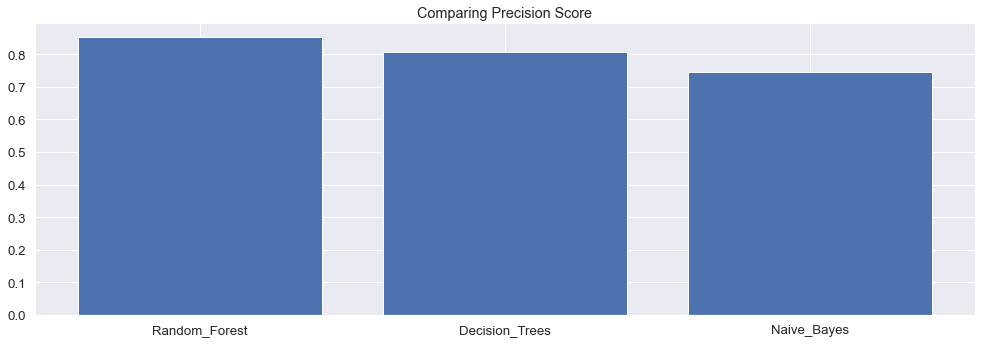

In [112]:
Precision = [precision_score_RF, precision_score_DT, precision_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Precision_pos = np.arange(len(Methods))
plt.bar(Precision_pos, Precision)
plt.xticks(Precision_pos, Methods)
plt.title('Comparing Precision Score')
plt.show()

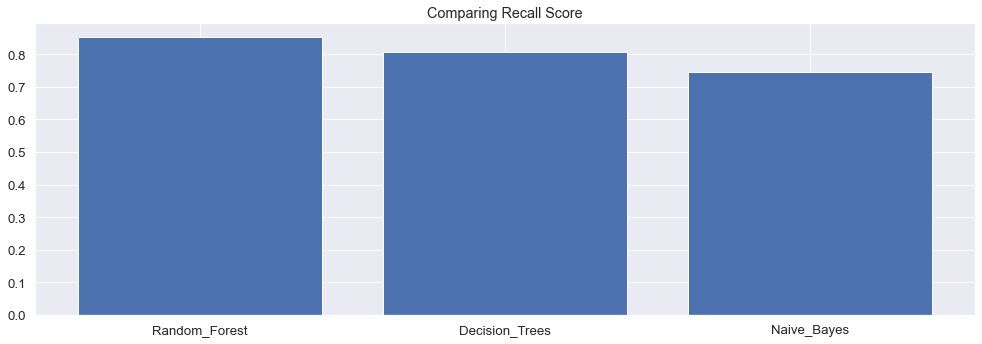

In [113]:
Recall = [recall_score_RF, recall_score_DT, recall_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Recall_pos = np.arange(len(Methods))
plt.bar(Recall_pos, Recall)
plt.xticks(Recall_pos, Methods)
plt.title('Comparing Recall Score')
plt.show()

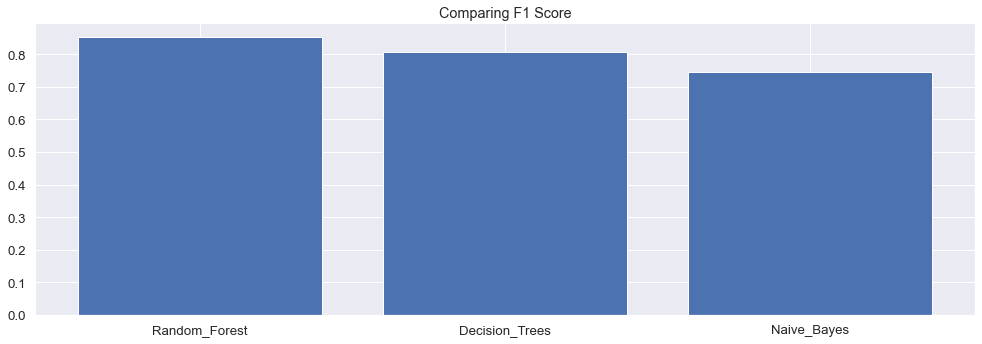

In [114]:
F1 = [f1_score_RF,f1_score_DT,f1_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
F1_pos = np.arange(len(Methods))
plt.bar(F1_pos, F1)
plt.xticks(F1_pos, Methods)
plt.title('Comparing F1 Score')
plt.show()

IT MEANS THAT RANDOM FOREST CLASSIFIER WORKS BEST 